In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
40323,NaN,NaN,International,2020-08-27,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40324,NaN,NaN,International,2020-08-28,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40325,NaN,NaN,International,2020-08-29,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


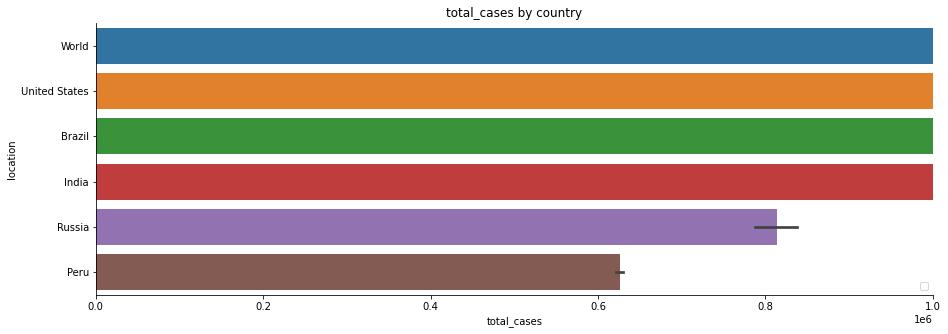

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


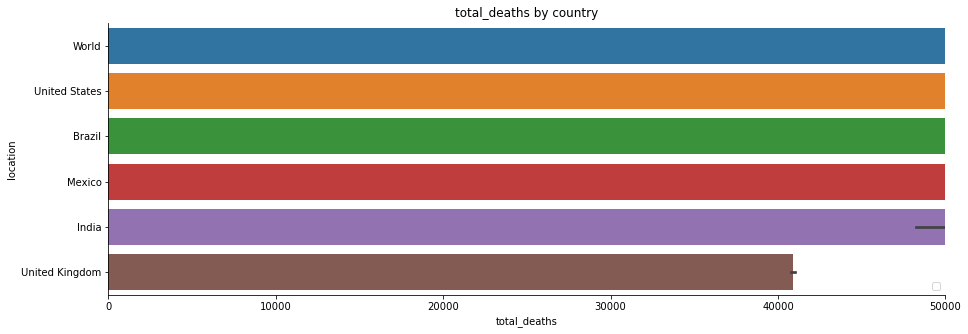

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


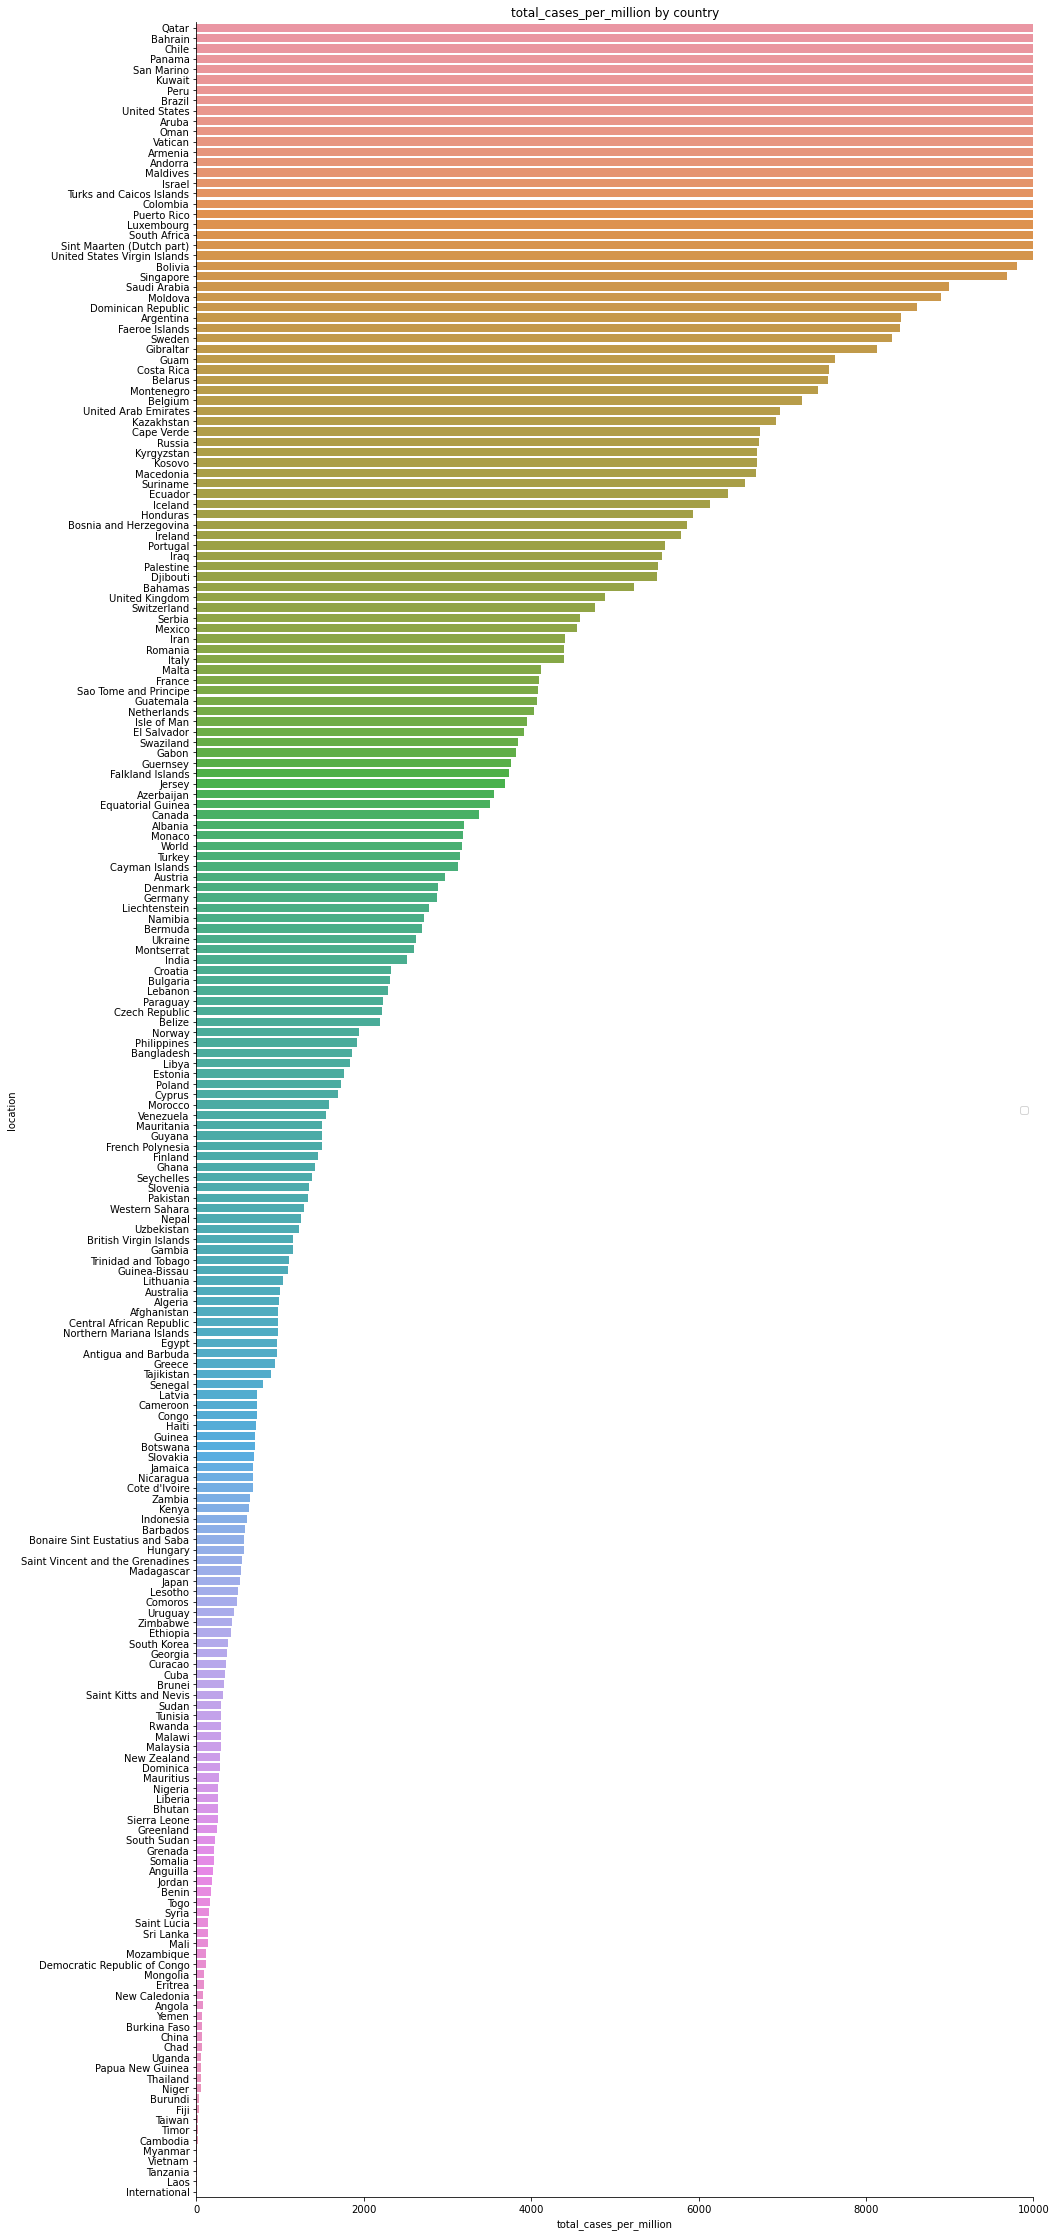

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


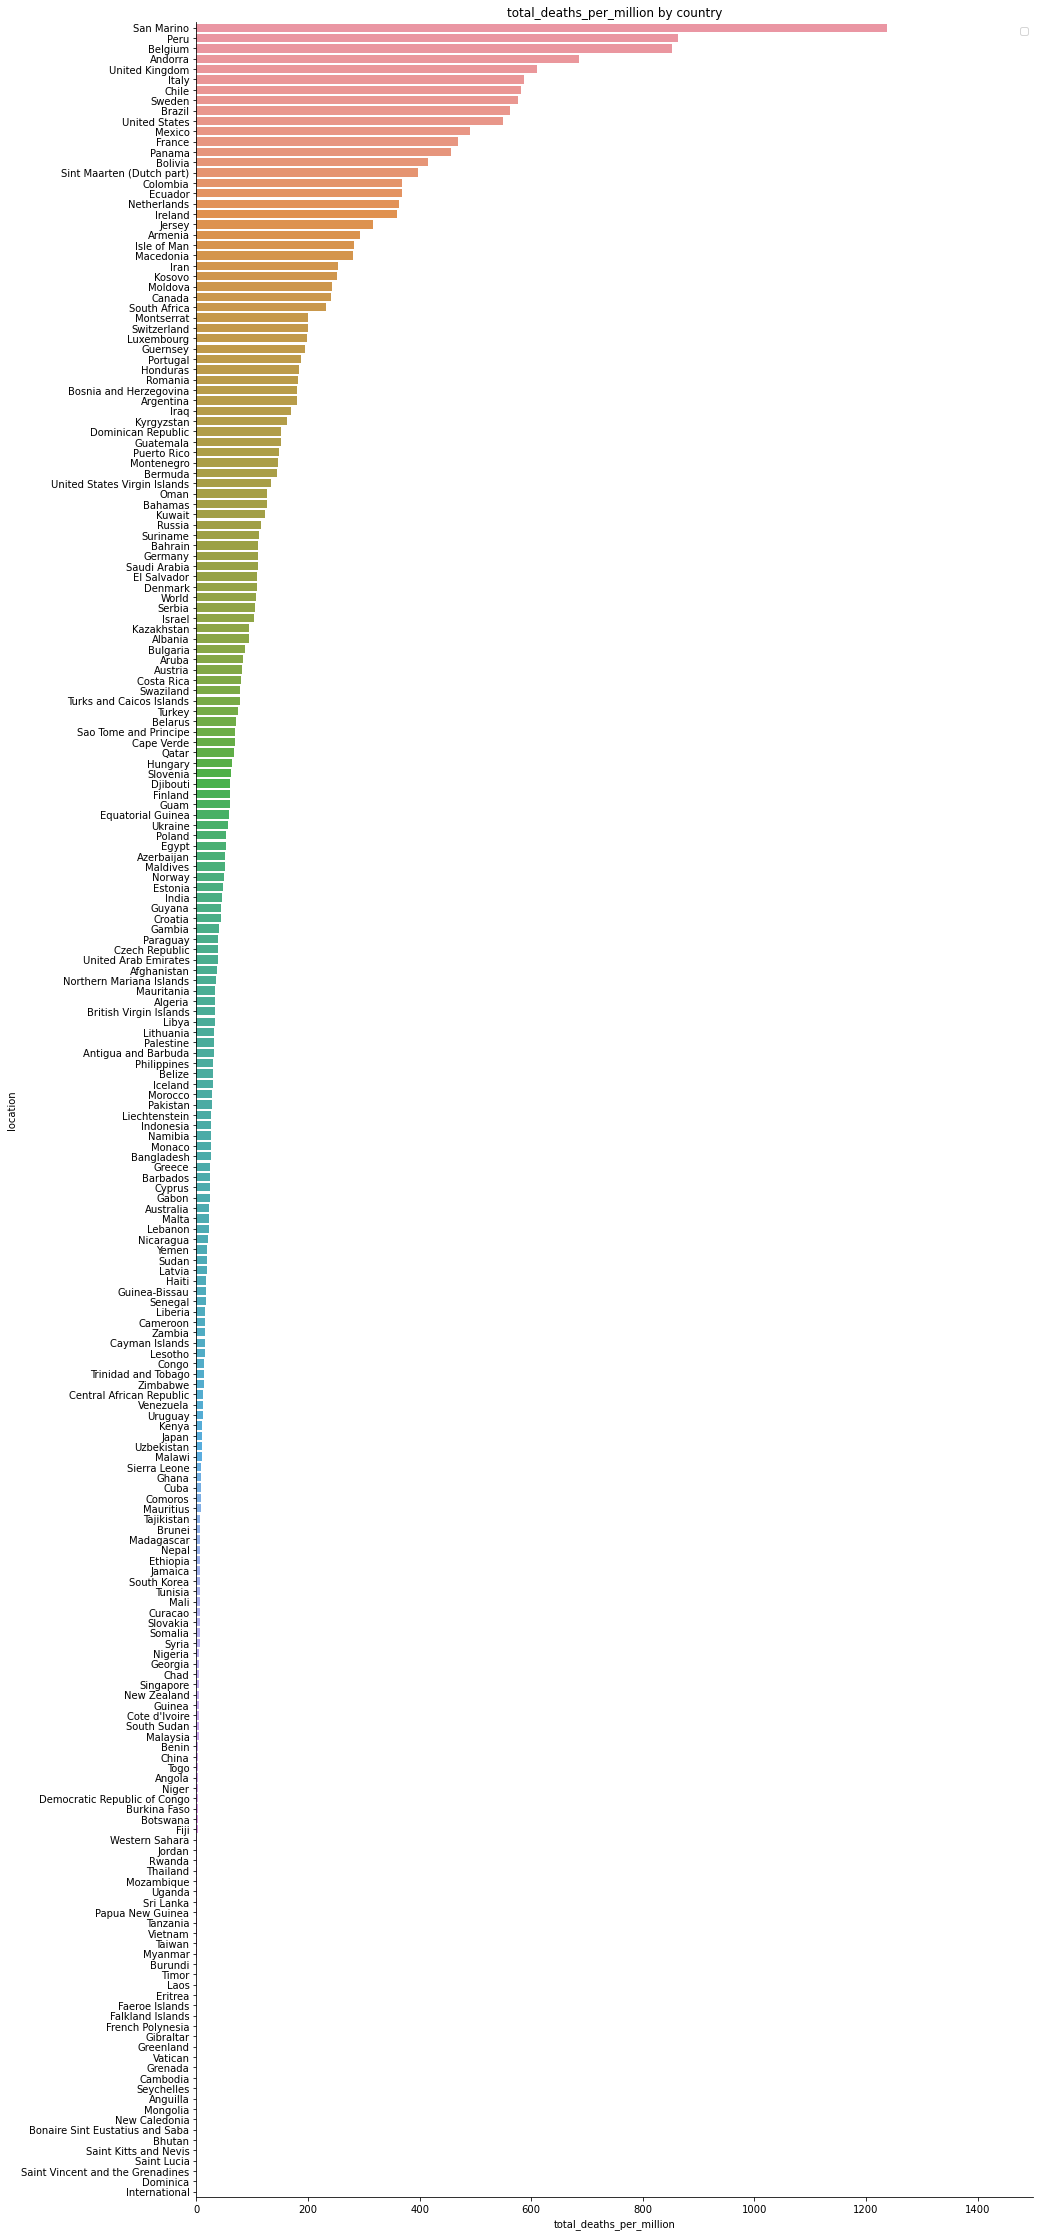

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

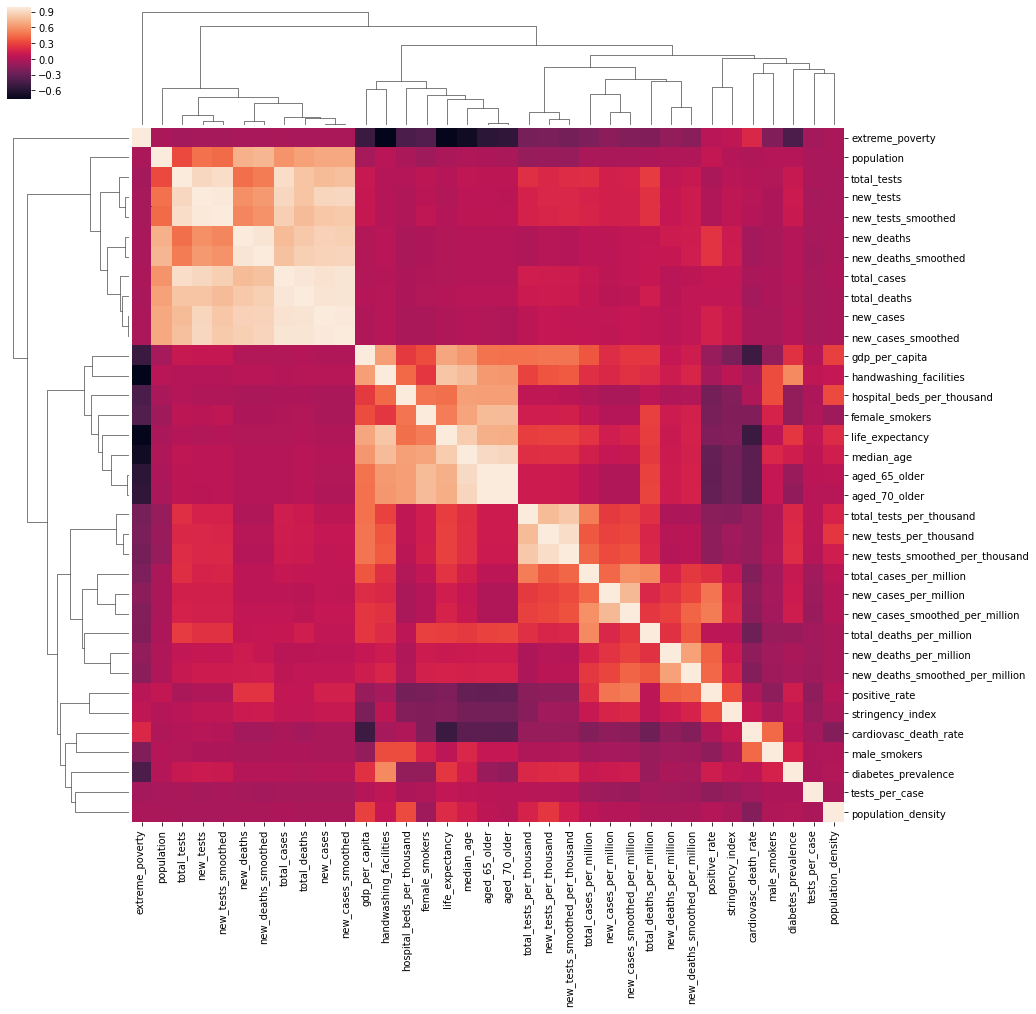

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994331230928557 (+/- 0.00042851724809703576)
Coef :  [1.03813541e+00 9.22725873e-05 9.61331664e-05]
3 Last_days :  [[24211814 24484074 24760129]]
Today :  24760129
Prediction + :  459691
Tomorow :  25219820
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996090647367598 (+/- 0.00010803996598988243)
Coef :  [0.02697146 0.47619431 0.50706018]
3 Last_days :  [[826122 832019 837579]]
Today :  837579
Prediction + :  8116
Tomorow :  845695
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9886016739518279 (+/- 0.008669961375162141)
Coef :  [-0.70244435  0.73979328  0.96485357]
3 Last_days :  [[253587 259698 267077]]
Today :  267077
Prediction + :  4797
Tomorow :  271874
                                     
--------- Total Death -----------------
                                     
R^2: 0.3621852634712381 (+/- 0.8909010385249008)
Coef :  [-0.75276368  0.78867785  0.96314328]
3 Last_days :  [[30544 30576 30596]]
Today :  30596
Prediction + :  46
Tomorow :  30642
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8899280158121169 (+/- 0.08620052571287189)
Coef :  [-0.32436448 -0.02036401  1.33899733]
3 Last_days :  [[89784 89814 89836]]
Today :  89836
Prediction + :  30
Tomorow :  89866
                                     
--------- Total Death -----------------
                                     
R^2: -262.2925372946025 (+/- 372.19175739451566)
Coef :  [-0.07695405  0.01243838  1.05644499]
3 Last_days :  [[4713 4715 4718]]
Today :  4718
Prediction + :  6
Tomorow :  4724
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.32823981822683956 (+/- 0.9488297494138769)
Coef :  [-0.82951393  0.90087339  0.92792831]
3 Last_days :  [[262540 263949 265409]]
Today :  265409
Prediction + :  1255
Tomorow :  266664
                                     
--------- Total Death -----------------
                                     
R^2: 0.9082796036813265 (+/- 0.10437013549862326)
Coef :  [-0.83005287  0.90030413  0.92888105]
3 Last_days :  [[35458 35463 35472]]
Today :  35472
Prediction + :  25
Tomorow :  35497
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9289281845994873 (+/- 0.09086584066612016)
Coef :  [-0.60104393  0.43840728  1.16428593]
3 Last_days :  [[419849 429507 439286]]
Today :  439286
Prediction + :  8346
Tomorow :  447632
                                     
--------- Total Death -----------------
                                     
R^2: 0.11674824506842933 (+/- 1.0361053579505182)
Coef :  [-0.72348135  0.62192192  1.10055075]
3 Last_days :  [[28971 28996 29011]]
Today :  29011
Prediction + :  28
Tomorow :  29039
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9919575769758202 (+/- 0.011121727354311661)
Coef :  [0.06927861 0.46987076 0.47733607]
3 Last_days :  [[5821876 5867785 5917439]]
Today :  5917439
Prediction + :  80711
Tomorow :  5998150
                                     
--------- Total Death -----------------
                                     
R^2: 0.4523288414061575 (+/- 0.7727170842182635)
Coef :  [-0.55431298  0.73726766  0.81962831]
3 Last_days :  [[179714 180824 181773]]
Today :  181773
Prediction + :  1218
Tomorow :  182991
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9882200820598451 (+/- 0.01529355847968955)
Coef :  [-0.74699316  0.86087684  0.88625701]
3 Last_days :  [[328846 330368 331644]]
Today :  331644
Prediction + :  1532
Tomorow :  333176
                                     
--------- Total Death -----------------
                                     
R^2: 0.40325450217545705 (+/- 0.8130239005313667)
Coef :  [-0.77309604  0.83211058  0.94041083]
3 Last_days :  [[41465 41477 41486]]
Today :  41486
Prediction + :  46
Tomorow :  41532
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.986373623197197 (+/- 0.01732350034384985)
Coef :  [-0.80116396  0.85945821  0.94141255]
3 Last_days :  [[237936 239507 240986]]
Today :  240986
Prediction + :  1403
Tomorow :  242389
                                     
--------- Total Death -----------------
                                     
R^2: 0.4078552003613006 (+/- 0.8257034820076746)
Coef :  [-0.79281048  0.8415276   0.9506156 ]
3 Last_days :  [[9285 9288 9289]]
Today :  9289
Prediction + :  9
Tomorow :  9298
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.9866647085645511 (+/- 2.808517394437566)
Coef :  [0.21222429 0.40261297 0.39715068]
3 Last_days :  [[363363 367796 369911]]
Today :  369911
Prediction + :  3516
Tomorow :  373427
                                     
--------- Total Death -----------------
                                     
R^2: 0.8961586229064081 (+/- 0.14618053706944356)
Coef :  [9.56374093e-05 5.14246203e-01 4.98217546e-01]
3 Last_days :  [[20901 21137 21249]]
Today :  21249
Prediction + :  258
Tomorow :  21507
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.997987240121355 (+/- 0.0025522702756890538)
Coef :  [-0.74206509  0.85050992  0.88887875]
3 Last_days :  [[262507 263998 265515]]
Today :  265515
Prediction + :  1240
Tomorow :  266755
                                     
--------- Total Death -----------------
                                     
R^2: 0.999031502159727 (+/- 0.0009555077688357209)
Coef :  [-0.81183469  0.89477302  0.91410976]
3 Last_days :  [[6183 6209 6245]]
Today :  6245
Prediction + :  21
Tomorow :  6266
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.46069967632526704 (+/- 0.7584455768796862)
Coef :  [-0.1556411   0.50195744  0.67026556]
3 Last_days :  [[3717156 3761391 3804803]]
Today :  3804803
Prediction + :  60871
Tomorow :  3865674
                                     
--------- Total Death -----------------
                                     
R^2: 0.4974753187496388 (+/- 0.7030956090804122)
Coef :  [-0.12361916  0.52298692  0.61350364]
3 Last_days :  [[117665 118649 119504]]
Today :  119504
Prediction + :  1569
Tomorow :  121073
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(24760129, 837579, 25219820, 845695),
 (267077, 30596, 271874, 30642),
 (265409, 35472, 266664, 35497),
 (439286, 29011, 447632, 29039),
 (5917439, 181773, 5998150, 182991),
 (89836, 4718, 89866, 4724),
 (331644, 41486, 333176, 41532),
 (240986, 9289, 242389, 9298),
 (369911, 21249, 373427, 21507),
 (265515, 6245, 266755, 6266),
 (3804803, 119504, 3865674, 121073)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-29,France,271874.0,0.0,30642.0,0.0,0.0,0.0
0,2020-08-29,China,89866.0,0.0,4724.0,0.0,0.0,0.0
0,2020-08-29,Italy,266664.0,0.0,35497.0,0.0,0.0,0.0
0,2020-08-29,Spain,447632.0,0.0,29039.0,0.0,0.0,0.0
0,2020-08-29,United States,5998150.0,0.0,182991.0,0.0,0.0,0.0
0,2020-08-29,World,25219820.0,0.0,845695.0,0.0,0.0,0.0
0,2020-08-29,United Kingdom,333176.0,0.0,41532.0,0.0,0.0,0.0
0,2020-08-29,Germany,242389.0,0.0,9298.0,0.0,0.0,0.0
0,2020-08-29,Iran,373427.0,0.0,21507.0,0.0,0.0,0.0
0,2020-08-29,Turkey,266755.0,0.0,6266.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")